# Sensor Component Failure Prediction

## 1) Problem statement

**Data:** Sensor Data

**Problem Statement:**

- The system in focus is the Air Pressure System (APS) which generates pressurized air that are utilized in various functions in a truck, such as braking and gear changes. The datasets positive class corresponds to component failures for a specific component of the APS system. The negative class corresponds to trucks with failures for components not related to the APS system.

- The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize the false predictions.

| **True class** | **Positive** | **Negative** 
--- | --- | ---
**Predicted class**
Positive | - | cost_1
Negative | cost_2 | - 

**Confusion Matrix:**

| **True class** | **Positive** | **Negative** 
--- | --- | ---
**Predicted class**
Positive | TP | FP
Negative | FN | TN 

Cost_1 = 10 and Cost_2 = 500

- The total cost of a prediction model the sum of `Cost_1` multiplied by the number of instances with type 1 failure and `Cost_2` with the number of instances with type 2 failure, resulting in a `Total_cost`. In this case `Cost_1` referes to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while `Cost_2` refer to the cost of missing a faulty truck, which may cause a breakdown.

- $\text{Total Cost = Cost1 x No Instances + Cost2 x No Instances}$

- from the above problem statement we could observe that, we have to reduce false positive and false negatives, More importantly we have to **reduce false negative, since cost incurred due to false negative is 50 times higher than the false positives.**

## Challenges and other objectives

- Need to Handle many Null values in almost all columns
- No low-latency requirement.
- Interpretability is not important.
- misclassification leads the unecessary repair costs.

## 2) Import reuiqred libraries

In [64]:
# data wrangling components
import pandas as pd
import numpy as np

# stats components
from statistics import mean
from sklearn.utils import resample

# visualization components
import matplotlib.pyplot as plt
import seaborn as sns

# pipeline components
from sklearn.preprocessing import PowerTransformer, LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# evaluation components
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay,\
     precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

# utils
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### **Read Data**

In [65]:
# load csv file
df = pd.read_csv('data/aps_failure_training_set1.csv', na_values="na")

In [66]:
# check rows and columns on the dataset
df.shape

(36188, 171)

In [67]:
# check unique values of target variables
df['class'].value_counts()

class
neg    35188
pos     1000
Name: count, dtype: int64

In [68]:
# define numerical & categorical columns
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features: {}'.format(len(numerical_features), numerical_features))
print('We have {} categorical features: {}'.format(len(categorical_features), categorical_features)) 

We have 170 numerical features: ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000',

### As this is a Sensor data. Interpretation of the data is not required

## **Checking missing values**

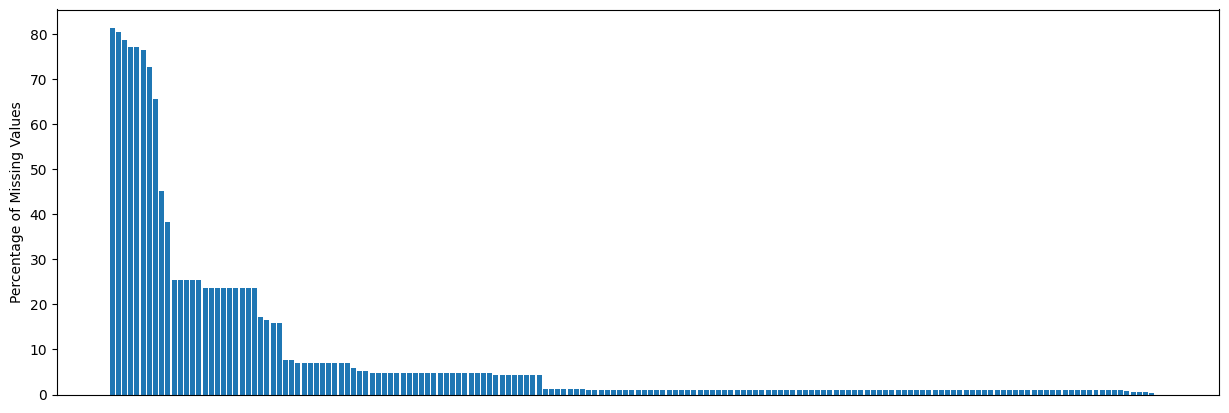

In [69]:
# Plotting Missing values count for each column
fig, ax = plt.subplots(figsize=(15, 5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending=False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage of Missing Values")
plt.show()

## **Dropping Columns which has more than 70% of missing values.**

In [70]:
## Drpooing columns which has more than 70% of missing values
dropcols = missing[missing[0] > 70]
dropcols

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
ab_000,77.086327
cr_000,77.086327
bo_000,76.533658
bn_000,72.761689


In [71]:
df.drop(list(dropcols.index), axis=1, inplace=True)

In [72]:
# check shape of the dataset after dropping columns
df.shape

(36188, 164)

### **Check the total percentage of missing values of full dataset after dropping columns with more than 70% of missing values**

In [73]:
missing_values_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# precent of data that is missing
print(f"Percentage of total missing cells in the data {(total_missing / total_cells) * 100:.2f}%")

Percentage of total missing cells in the data 5.37%


## **Visualization of unique values in Target variable**

Positive: 1000, Negative: 35188


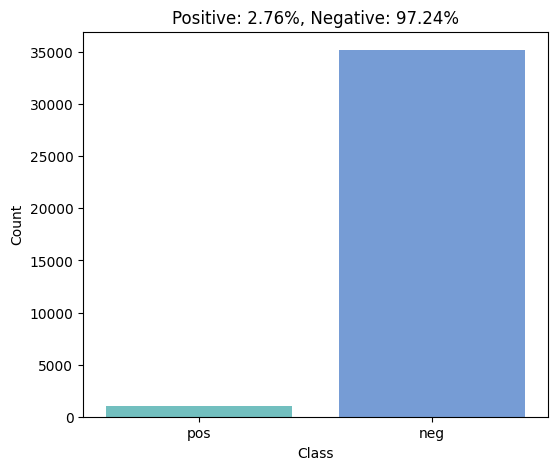

In [74]:
pos = df[df['class'] == 'pos'].shape[0]
neg = df[df['class'] == 'neg'].shape[0]
print("Positive: "+str(pos)+", Negative: "+str(neg))
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x="class", palette="winter_r", alpha=0.6)
plt.title(f"Positive: {np.round(pos*100/df.shape[0], 2)}%, Negative: {np.round(neg*100/df.shape[0], 2)}%")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**Report**

- The target classes are highly imabalanced.
- Class imabalanced is a scenario that arises when we have unequal distribution of classes in a dataset i.e., the no of data points in the negative class (majority class) very large compared to that of the positive (minority class).
- If the imabalanced data is not treated beforehand, then this will degrade the performance of the classifier model.
- Hence we should handle imbalanced data with certain methods.

**How to handle Imbalanced data ?**

- Resmapling is one of the most commeonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this 

    i. Undersampling

    ii. Oversampling

In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information.

- **SMOTE**: Synthetic Minority Oversmapling Technique
- SMOTE is an oversampling technique where the synthetic smaples are generated for the minority class.
- Hybridization techniques involved combining both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the smaples created as part of these techniques.
- It only duplicates the data and it won't add and new information. Hence we look at some different techniques.

## **Create Functions for model training and evaluation**

In [75]:
def evaluate_clf(true, predicted):
    """ 
    This function takes in true values and predicted values
    Returns: Accuracy, F1 score, Precision, Recall, AUC ROC Curve
    """
    acc = accuracy_score(true, predicted) # Calculate accuracy
    f1 = f1_score(true, predicted) # Calculate F1 score
    precision = precision_score(true, predicted) # Calculate precision
    recall = recall_score(true, predicted) # Calculate recall
    roc_auc = roc_auc_score(true, predicted) # Calculate AUC ROC Curve
    return acc, f1, precision, recall, roc_auc

In [76]:
# create the cost of the model as per the data description
def total_cost(y_ture, y_pred):
    """ 
    This function takes the y_ture and y_pred and calculates the total cost due to misclassification
    """
    tn, fp, fn, tp = confusion_matrix(y_ture, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [77]:
# Create function which can evaluate the model and return report
def evaluate_model(X, y, models):
    """ 
    This function takes in X, y and models dictionary input
    It splits the data into Train Test Split
    Iterates through the given model directory and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    """
    # Seperate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    cost_list = []
    models_list = []
    accuracy_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) #  Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision, model_train_recall, model_train_roc_auc = evaluate_clf(y_train, y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)

        # Test set performance
        model_test_accuracy, model_test_f1, model_test_precision, model_test_recall, model_test_roc_auc = evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print("Model Performance on Training Set")
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print("- F1 score: {:.4f}".format(model_train_f1))
        print("- Precision: {:.4f}".format(model_train_precision))
        print("- Recall: {:.4f}".format(model_train_recall))
        print("- Roc Auc Score: {:.4f}".format(model_train_roc_auc))
        print(f'- COST: {train_cost}')

        print('-------------------------------------------')

        print("Model Performance on Test Set")
        print("- Accuracy: {:.4f}".format(model_test_accuracy))
        print("- F1 score: {:.4f}".format(model_test_f1))
        print("- Precision: {:.4f}".format(model_test_precision))
        print("- Recall: {:.4f}".format(model_test_recall))
        print("- Roc Auc Score: {:.4f}".format(model_test_roc_auc))
        print(f'- COST: {test_cost}')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
    report = pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by="Cost")

    return report


### **Plot distribution of all Independent Numerical variables**

KeyboardInterrupt: 

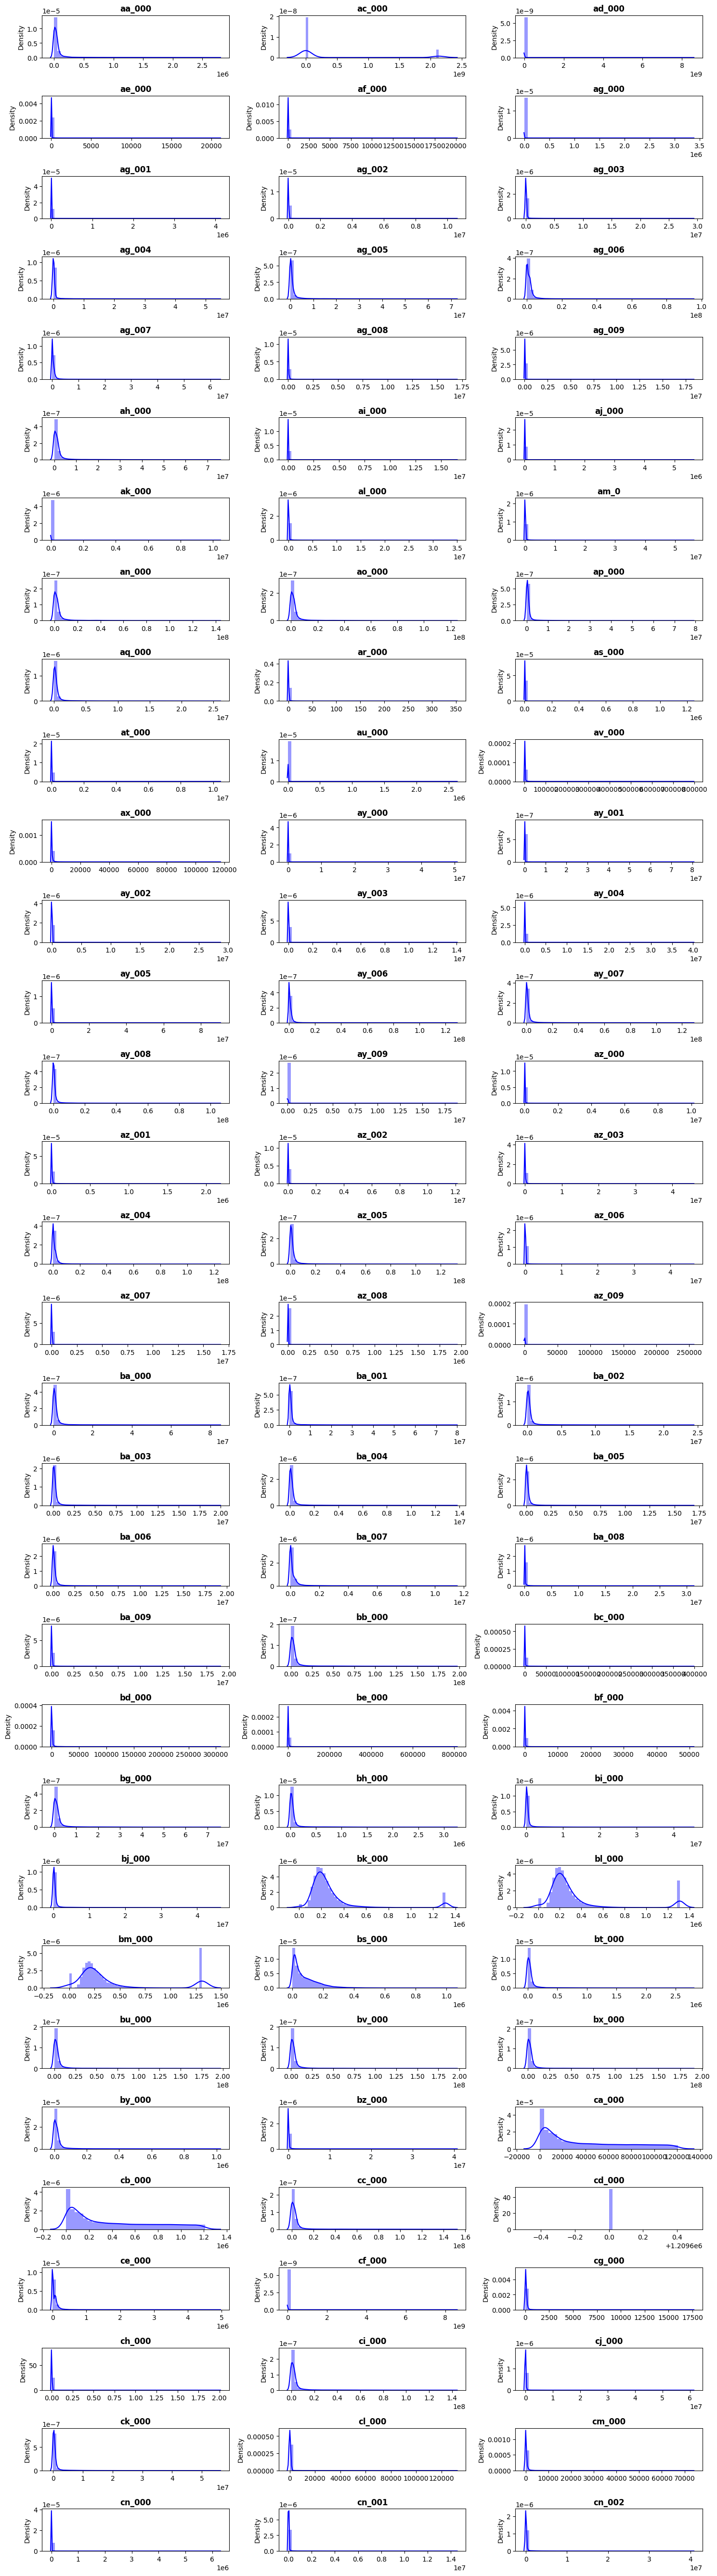

In [78]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='blue')
    plt.title(col, weight='bold')
    plt.tight_layout()

- interpreting each and every column is not necessary as this is sensor data.

## Evaluate Model on Different experiments

In [ ]:
# Splitting X and y for all experiments
X = df.drop('class', axis=1)
y = df['class']

- **Manually Encoding Target Variable**

In [ ]:
y = y.replace({'pos': 1, 'neg': 0})

## **Experiment: 1 = KNN Imputer for Null values**

**Why Robust scaler and not Standard scaler ?**

- Scaling the data using Robust scaler
- Since most of the independent variables are not normally distributed we cannot use Standardscaler

**Why Robust Scaler and not Minmax ?**

- because most of the feature has outliers, So Minmax will scale data according to Max values which is outlier.
- This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quantile (25th quantile) and the 3rd quantile (75th quantile).

In [17]:
# fit with robust scaler for KNN best k-selection experiment
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

**Why KNN Imputer ?**

- KNNImputer by scikit-learn is a widely used method to impute missing value. It is widely being observed as a replacement for treditional imputation techniques.
- KNNImputer helps to impute missing values present in the observation by finding the nearest neighbours with the Euclidean distance matrix.
- Here we iterates through different k values and get accuracy and choose best k values.

**Finding the optimal n_neighbour values for KNN imputer**

In [51]:
results = []
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1, 3, 5, 7, 9]]
for s in strategies:
    pipeline = Pipeline(steps=[
        ('i', KNNImputer(n_neighbors=int(s))), 
         ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print('n_neighbours= %s | accuracy (%.4f)' % (s, mean(scores)))

/Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/sensor_fault_detection/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/sensor_fault_detection/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

n_neighbours= 1 | accuracy (0.7223)


/Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/sensor_fault_detection/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/sensor_fault_detection/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

n_neighbours= 3 | accuracy (0.7243)


/Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/sensor_fault_detection/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/sensor_fault_detection/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

n_neighbours= 5 | accuracy (0.7018)


/Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/sensor_fault_detection/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/sensor_fault_detection/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

n_neighbours= 7 | accuracy (0.6982)


/Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/sensor_fault_detection/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/sensor_fault_detection/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

n_neighbours= 9 | accuracy (0.7260)


**We can observe n_neighbours=3 able to produce highest accuracy**

### Pipeline for KNN imputer

In [41]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the KNN imputer with selected k-value
knn_pipeline = Pipeline(
    steps=[
        ('imputer', KNNImputer(n_neighbors=9)),
        ('RobustScaler', RobustScaler())
    ]
)

In [44]:
x_knn = knn_pipeline.fit_transform(X)

### Handling Imbalanced Data

**SMOTE + TOMEK** is one of such hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.

- This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class

- To add new data of minority data

1. Choose random data from the minority class
2. Calculate the distance between the random data and its k nearest neighbours.
3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
4. Repeat stem number 2-3 until the desired propotion of minority class is met.

- To remove the tomek links of the majority class

1. Choose random data from majority class.
2. If the random data's nearest neighbour is the data from the minority class (i.e, create the Tomek Link), then remove the Tomek Link.

- This is method instead of adding duplicate data it synthesises the new data based on the already available classes. Hence we choose this as our imputer method for this problem.

In [45]:
from imblearn.combine import SMOTETomek

# Resampling the monority class. The stratgey can change as required.
smt = SMOTETomek(sampling_strategy='minority', random_state=42, n_jobs=-1)

# Fit the model to generate the data
X_res, y_res = smt.fit_resample(x_knn, y)

### Initialize Default Models in a dictionary

In [46]:
# Dictionary shich contains model for experiment
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
    "CatBoostClassifier": CatBoostClassifier(random_state=42, verbose=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=42),
}

### **Fit KNN imputed data for models in dictionary**

In [61]:
report_knn = evaluate_model(X_res, y_res, models)

Random Forest
Model Performance on Training Set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9913
- F1 score: 0.9913
- Precision: 0.9871
- Recall: 0.9956
- Roc Auc Score: 0.9913
- COST: 16410


Decision Tree
Model Performance on Training Set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9853
- F1 score: 0.9854
- Precision: 0.9811
- Recall: 0.9897
- Roc Auc Score: 0.9853
- COST: 37340


Gradient Boosting
Model Performance on Training Set
- Accuracy: 0.9838
- F1 score: 0.9839
- Precision: 0.9807
- Recall: 0.9871
- Roc Auc Score: 0.9838
- COST: 185960
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9805
- F1 score: 0.9806
- Precision: 0.9756
- Recall: 

### Report for KNN Imputed data

In [62]:
report_knn

,Model Name,Cost
5,XGBClassifier,4050
6,CatBoostClassifier,9150
0,Random Forest,16410
1,Decision Tree,37340
4,K-Nearest Neighbors,44950
2,Gradient Boosting,51730
7,AdaBoostClassifier,96790
3,Logistic Regression,258400


**Insights**

- For the Experiment 1: Knn imputer has XGBoost classifier as the best model
- Processing with further experiments

## **Experiment: 2 = Simple Imputer with Strategy Median**

- SimpleImputer is a class in the `sklearn.impute` module that can be used to replace missing values in a dataset, using a variety of input strategies.

- Here we use SimpleInputer can also be used to impute multiple columns at once by passing in a list of column names. SimpleImputer will then replace missing values in all of the specified columns.

In [68]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the simple imputer with strategy median
median_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('RobustScaler', RobustScaler())
    ]
)

In [69]:
# Fit X with median_pipeline
X_median = median_pipeline.fit_transform(X1)

In [70]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(sampling_strategy='minority', random_state=42, n_jobs=-1)

# Fit the mdoel to generate the data
X_res, y_res = smt.fit_resample(X_median, y)

In [71]:
# Training the model
report_median = evaluate_model(X_res, y_res, models)

Random Forest
Model Performance on Training Set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9922
- F1 score: 0.9923
- Precision: 0.9896
- Recall: 0.9949
- Roc Auc Score: 0.9922
- COST: 18730


Decision Tree
Model Performance on Training Set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9853
- F1 score: 0.9854
- Precision: 0.9830
- Recall: 0.9877
- Roc Auc Score: 0.9853
- COST: 44200


Gradient Boosting
Model Performance on Training Set
- Accuracy: 0.9831
- F1 score: 0.9831
- Precision: 0.9806
- Recall: 0.9856
- Roc Auc Score: 0.9831
- COST: 207960
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9832
- F1 score: 0.9832
- Precision: 0.9826
- Recall: 

### Report for Simple Imputer with median strategy

In [81]:
report_median

,Model Name,Cost
5,XGBClassifier,8910
6,CatBoostClassifier,11550
0,Random Forest,18730
1,Decision Tree,44200
4,K-Nearest Neighbors,54750
2,Gradient Boosting,58220
7,AdaBoostClassifier,92410
3,Logistic Regression,146420


**Insights**

- For the Experiment 2: Simple imputer with median strategy has XGBoost has the best model

- Proceeding with further experiments.

## **Experiment: 3 = MICE for Imputing Null values**

- MICE stands for Multiavriate Imputation By Chained Equation algorithm.

- This technique by which we can effortlessly impute missing values in a dataset by looking at data from other columns and trying to estimate the best prediction for each missing value.

- `ImputationKernel` Creates a kernel dataset, This dataset can perform MICE on itself, and impute new data from models obtained during MICE.

In [ ]:
# !pip install -q miceforest

In [74]:
import miceforest as mf

X_mice = X.copy()
kernel = mf.ImputationKernel(
    X_mice,
    save_all_iterations=True,
    random_state=1998
)# Run the MICE algorithm for 3 iterations kernel.mice(3)

In [75]:
X_mice = kernel.complete_data()

In [76]:
mice_pipeline = Pipeline(
    steps=[
        ('RobustScaler', RobustScaler())
    ]
)

In [77]:
# Fit X with Mice imputer
X_mice = mice_pipeline.fit_transform(X_mice)

In [79]:
# Resmapling the minority class, The strategy can be changed as required.
smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)
# Fit the mdoel to generate the data
X_res, y_res = smt.fit_resample(X_mice, y)

In [80]:
# Training the model
report_mice = evaluate_model(X_res, y_res, models)

Random Forest
Model Performance on Training Set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9900
- F1 score: 0.9901
- Precision: 0.9845
- Recall: 0.9957
- Roc Auc Score: 0.9900
- COST: 16100


Decision Tree
Model Performance on Training Set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9835
- F1 score: 0.9835
- Precision: 0.9784
- Recall: 0.9887
- Roc Auc Score: 0.9835
- COST: 41030


Gradient Boosting
Model Performance on Training Set
- Accuracy: 0.9846
- F1 score: 0.9846
- Precision: 0.9820
- Recall: 0.9873
- Roc Auc Score: 0.9846
- COST: 182590
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9826
- F1 score: 0.9827
- Precision: 0.9776
- Recall: 

### Report for MICE Imputer algorithm

In [82]:
report_mice

,Model Name,Cost
5,XGBClassifier,5990
6,CatBoostClassifier,8550
0,Random Forest,16100
1,Decision Tree,41030
2,Gradient Boosting,44090
4,K-Nearest Neighbors,60060
7,AdaBoostClassifier,86020
3,Logistic Regression,195430


**Insights**

- For the Experiment 3: MICE imputer with median strategy has XGBoost has the best model

- Proceeding with further experiments.

## **Experiment: 4 = Simple Imputer with Strategy Constant**

- Another strategy which can be used is replacing missing values with a fixed (Constant) values.

- To do this, specify "constant" for strategy and scpecify the fill value using the fill_value parameter

In [38]:
# Create a pipeline with simple imputer with strategy constant and fill value 0
constant_pipeline = Pipeline(
    steps=[
        ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('RobustScaler', RobustScaler())
    ]
)

In [39]:
x_const = constant_pipeline.fit_transform(X)

In [40]:
# Resampling the minority class. The stratgey can be changed as required.
smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(x_const, y)

NameError: name 'SMOTETomek' is not defined

In [86]:
# Training the model
report_constant = evaluate_model(X_res, y_res, models)

Random Forest
Model Performance on Training Set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9919
- F1 score: 0.9920
- Precision: 0.9880
- Recall: 0.9960
- Roc Auc Score: 0.9919
- COST: 14850


Decision Tree
Model Performance on Training Set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9872
- F1 score: 0.9872
- Precision: 0.9836
- Recall: 0.9909
- Roc Auc Score: 0.9872
- COST: 33160


Gradient Boosting
Model Performance on Training Set
- Accuracy: 0.9831
- F1 score: 0.9832
- Precision: 0.9799
- Recall: 0.9865
- Roc Auc Score: 0.9831
- COST: 195670
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9803
- F1 score: 0.9804
- Precision: 0.9783
- Recall: 

### Report for Simple Imputer with Constant Strategy

In [87]:
report_constant

,Model Name,Cost
5,XGBClassifier,5550
6,CatBoostClassifier,7220
0,Random Forest,14850
1,Decision Tree,33160
4,K-Nearest Neighbors,40200
2,Gradient Boosting,63030
7,AdaBoostClassifier,104350
3,Logistic Regression,131210


**Insights**

- For the Experiment 3: MICE imputer with median strategy has XGBoost has the best model

- Proceeding with further experiments.

## **Experiment: 5 = Simple Imputer with Strategy Mean**

- Another strategy which can be used is replacing missing values with mean.

- Here we replace the missing values with the mean of the column

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('RobustScaler', RobustScaler()),
    ]
)

In [20]:
X_pca = pca_pipeline.fit_transform(X)

In [21]:
# Applying PCA
from sklearn.decomposition import PCA
var_ratio = []
for n in range(2, 50):
    pca = PCA(n_components=n)
    df_pca= pca.fit(X_pca)
    var_ratio.append(df_pca.explained_variance_ratio_.sum())

### **Variance Plot**

<Axes: >

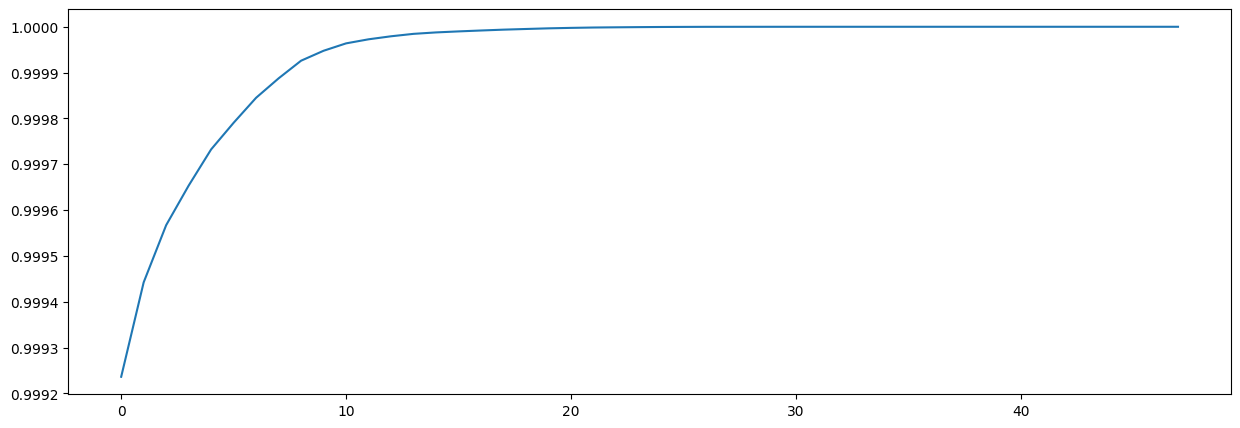

In [22]:
# plotting variance ratio
pd.Series(var_ratio).plot(figsize=(15, 5))

### **kneed algorithm to find the elbow point**

In [24]:
!pip install kneed

<Figure size 500x500 with 0 Axes>

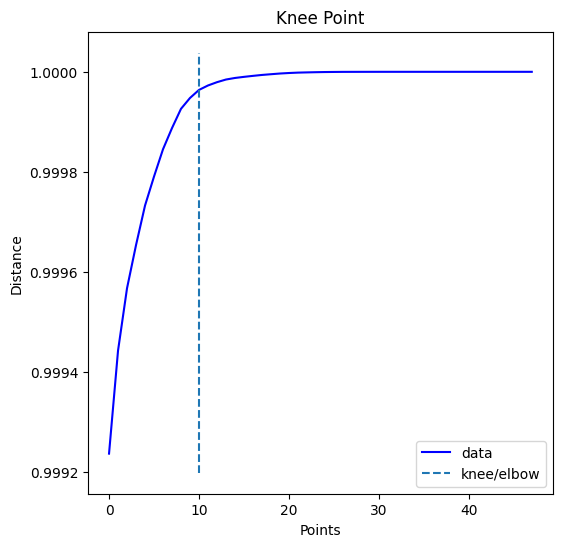

Knee Locator k =  10


In [35]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio = var_ratio.copy()
components = len(var_ratio)
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k = knee.knee
print("Knee Locator k = ", k)

In [48]:
# Reduce the dimenssions of the data 
pca_final = PCA(n_components=18, random_state=42).fit(X_res)

reduced = pca_final.fit_transform(X_pca)

In [49]:
# Resamoling the minority class. the startegy can be changed as required.
smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)

# Fit the model to generate data
X_res, y_res = smt.fit_resample(reduced, y)

In [50]:
# Training all models
report_pca = evaluate_model(X_res, y_res, models)

Random Forest
Model Performance on Training Set
- Accuracy: 0.9986
- F1 score: 0.9986
- Precision: 1.0000
- Recall: 0.9972
- Roc Auc Score: 0.9986
- COST: 39000
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9823
- F1 score: 0.9823
- Precision: 0.9783
- Recall: 0.9864
- Roc Auc Score: 0.9823
- COST: 49030


Decision Tree
Model Performance on Training Set
- Accuracy: 0.9986
- F1 score: 0.9986
- Precision: 1.0000
- Recall: 0.9972
- Roc Auc Score: 0.9986
- COST: 39000
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9743
- F1 score: 0.9743
- Precision: 0.9728
- Recall: 0.9758
- Roc Auc Score: 0.9743
- COST: 86410


Gradient Boosting
Model Performance on Training Set
- Accuracy: 0.9416
- F1 score: 0.9415
- Precision: 0.9427
- Recall: 0.9402
- Roc Auc Score: 0.9416
- COST: 851470
-------------------------------------------
Model Performance on Test Set
- Accuracy: 0.9412
- F1 score: 0.9409
- Precision: 0.9463
- 

### Report for PCA and Mean imputed data

In [51]:
report_pca

,Model Name,Cost
0,Random Forest,49030
5,XGBClassifier,67200
1,Decision Tree,86410
6,CatBoostClassifier,95440
4,K-Nearest Neighbors,111560
2,Gradient Boosting,229210
7,AdaBoostClassifier,295930
3,Logistic Regression,903370


# Final Model

In [53]:
!pip install -q prettytable

In [63]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = ["Model", "Imputation_method", "Total_cost"]
pt.add_row(["XGBClassifier", "Knn-Imputer-Constant", "4050"])
pt.add_row(["XGBClassifier", "Mice", "5990"])
pt.add_row(["XGBClassifier", "Knn-Imputer-Mean", ""])
pt.add_row(["XGBClassifier", "Simple-Imputer-Mean", ""])
pt.add_row(["XGBClassifier", "Simple-Imputer-Median", "8910"])
pt.add_row(["Random Forest", "PCA", "49030"])
print(pt)

+---------------+-----------------------+------------+
|     Model     |   Imputation_method   | Total_cost |
+---------------+-----------------------+------------+
| XGBClassifier |  Knn-Imputer-Constant |    4050    |
| XGBClassifier |          Mice         |    5990    |
| XGBClassifier |    Knn-Imputer-Mean   |            |
| XGBClassifier |  Simple-Imputer-Mean  |            |
| XGBClassifier | Simple-Imputer-Median |    8910    |
| Random Forest |          PCA          |   49030    |
+---------------+-----------------------+------------+


**Report**

- From the final report we can see that XGBClassifier with KNN Imputer with Constant imputation strategy has performed the best with cost of 4050

## Fitting the Final model and get reports

In [82]:
final_model = XGBClassifier()


# Resampling the minority class. The strategy can be changes as required
smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)

# Fit the model to generate the data
X_res, y_res = smt.fit_resample(x_const, y)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [86]:
print('Final XGBoost Classifier Cost Metric(Train) :', final_model.score(X_train, y_train))
print('Final XGBoost Classifier Cost Metric(Test) :', final_model.score(X_test, y_test))

Final XGBoost Classifier Cost Metric(Train) : 1.0
Final XGBoost Classifier Cost Metric(Test) : 0.9962925994581492


In [85]:
print('Final XGBoost Classifier Cost Metric(Test) :', total_cost(y_test, y_pred))

Final XGBoost Classifier Cost Metric(Test) : 2970


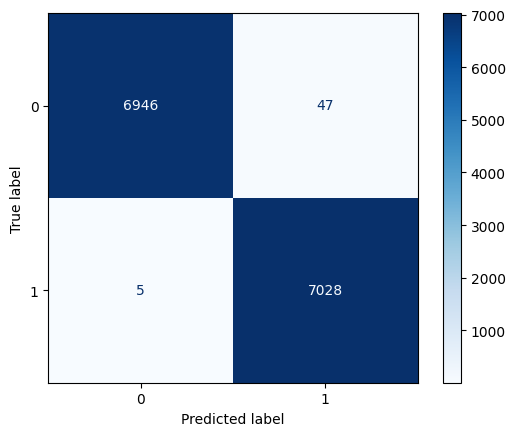

In [87]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test, cmap="Blues", values_format="d")


# The best model is XGBClassifier with - accuracy and cost of 2970